In [85]:
%matplotlib inline

In [86]:
from itertools import zip_longest, product,groupby
from numpy import pi, e, hstack, vstack, asarray
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import os

In [87]:
def glide (link):
    '''
    An implementation of the glide move using the oriented
    Gauss code instead of a Dowker-like code.
    
    Takes as input a Link, outputs a more complicated Link
    '''
    gauss, signs = link.oriented_gauss_code()
    
    for comp in range(len(gauss)):
        for n in range(len(gauss[comp])-1):
            a, b = gauss[comp][n], gauss[comp][n+1]
            if abs(a) == abs(b) and sign(a) < sign(b):
                pass
            elif sign(a) < sign(b):
                L = len(signs)+1
                R = L+1
                
                a_sign, b_sign = signs[abs(a)-1], signs[abs(b)-1]
                
                # add the other crossings first
                # a_idx and b_idx are the locations of the strand with opposite sign
                Acomp_idx = gauss.index(list(filter(lambda x: -a in x, gauss))[0])
                Bcomp_idx = gauss.index(list(filter(lambda x: -b in x, gauss))[0])
                a_idx = gauss[Acomp_idx].index(-a)
                b_idx = gauss[Bcomp_idx].index(-b)
                
                if a_sign == 1 and b_sign == 1:
                    gauss[Acomp_idx][a_idx] = [L,b,R]
                    gauss[Bcomp_idx][b_idx] = [-R,a,-L]
                    signs += [+1,-1]
                
                elif a_sign == 1 and b_sign == -1:
                    gauss[Acomp_idx][a_idx] = [L,b,R]
                    gauss[Bcomp_idx][b_idx] = [-L,a,-R]
                    signs += [-1,+1]
                    
                elif a_sign == -1 and b_sign == 1:
                    gauss[Acomp_idx][a_idx] = [R,b,L]
                    gauss[Bcomp_idx][b_idx] = [-R,a,-L]
                    signs += [-1,+1]
                else:
                    gauss[Acomp_idx][a_idx] = [R,b,L]
                    gauss[Bcomp_idx][b_idx] = [-L,a,-R]
                    signs += [+1, -1]

                # swap the orientations of a and b
                signs[abs(a)-1], signs[abs(b)-1] = signs[abs(b)-1], signs[abs(a)-1]
                # swap the signs of a and b
                gauss[comp][gauss[comp].index(a)] *= -1
                gauss[comp][gauss[comp].index(b)] *= -1
                # flatten the 
                gauss[Acomp_idx] = flatten(gauss[Acomp_idx])
                gauss[Bcomp_idx] = flatten(gauss[Bcomp_idx])
                break
                
    return Link([gauss, signs])

In [88]:
def nice_dowker(link):
    '''
    The built-in Dowker notation method does not order the strands,
    or at least I do not see that happening, so I made a version which does that
    '''
    gauss, signs = link.oriented_gauss_code()
    nice_dowker = [ [None,None] for i in range(len(signs))]
    counter = 1
    for i in range(len(gauss)):
        for j in range(len(gauss[i])):
            if sign(gauss[i][j]) == +1:
                nice_dowker[abs(gauss[i][j])-1][1] = counter
            else:
                nice_dowker[abs(gauss[i][j])-1][0] = counter
            counter +=1
    nice_dowker = [ tuple(i) for i in nice_dowker]
    return nice_dowker

In [89]:
# some useful function abstractions to make the later code readable
f0 = lambda x: x
f90 = lambda x:  np.rot90(x, k=1,axes=(0,1))
f180 = lambda x:  np.rot90(x, k=2,axes=(0,1))
f270 = lambda x:  np.rot90(x, k=3,axes=(0,1))
rotated = lambda x : [ f(x) for f in [f0, f90, f180, f270]]


def arrange_crossings (link):
    '''
    Takes a link, and attempts to organise the crossings on a grid, 
    as well as extra other visual elements. Outputs a Graphics object
    that can be plotted or saved
    
    It works by greedily focusing on the left most entries and depending on
    the structure below we take cases, it looks at each pair of strands in order and:
    (1) tries to connect a crossing to both strands
    (2) if not successful then tries to connect to the left one
    (3) checks if we can close the two strands
    
    The code is slow and not optimised
    '''
    
    # we get a "nice" dowker key and then order the crossings
    dowker = nice_dowker(link)
    final = max(flatten(dowker))
    
    # sort the dowker key by the min strand,
    # also we take into account that we need to sort the signs too
    dowker, signs = zip(*sorted(zip(dowker, link.orientation()), key= lambda x: min(x[0])))
    signs = list(signs)
    # we unwrap the dowker into 2x2 arrays the entries of which
    # are the numbers of the strands. the bottom numbers are coming in,
    # the top are coming out
    crossings = [np.array([[i[0]%final+1,i[1]%final+1],[i[1],i[0]]]) if j==1
                 else np.array([[i[1]%final+1,i[0]%final+1],[i[0],i[1]]])
                 for i,j in zip(dowker, signs)]
    crossings = [(n,i) for n,i in enumerate(crossings)]
        
    c_rotated = rotated(crossings[0][1])
    accepted = [ n for n, c in enumerate(c_rotated) if c[1][0] == 1 ]
    top_line = flatten([c_rotated[accepted[0]][0,:].tolist(),c_rotated[accepted[0]][1,1]])
    accepted = [ (accepted[0],signs[0],0)]
    crossings.pop(0)
    signs.pop(0)
    

    cross = [[(0,0), (0,1), (1,1), (1,0)]]
    lines = [[(0,1), (0,1), (0,1)],[(1,1), (1,1), (1,1)],[(1,0), (2,0), (2,1)]]
    extra_bits = []
    
    old = len(crossings)
    new = old - 1
    while top_line != [1]:
                
        checked = 0
        for i, (n, (m,c)) in product(range(len(top_line)-1),enumerate(crossings)):
            c_rotated = rotated(c)
            # check if we can connect two strands
            if top_line[i:i+2] in [ c_rot[1].tolist() for c_rot in c_rotated]:
                checked = 1
                c_rot = c_rotated[[ c_rot[1].tolist() for c_rot in c_rotated].index(top_line[i:i+2])]
                accepted += [([ c_rot[1].tolist() 
                                        for c_rot in c_rotated].index(top_line[i:i+2]),signs[n],m)]
                cx, cy = lines[i][2]
                cross += [[(cx,cy),(cx,cy+1),(cx+1,cy+1),(cx+1,cy)]]
                extra_bits += [lines[i],lines[i+1]]
                lines[i] = [(cx,cy+1)]*3
                lines[i+1] = [(cx+1,cy+1)]*3
                lines = [ lin if n==i or n==i+1 
                         else lin[:2]+[(lin[2][0],lin[2][1]+1)] for n,lin in enumerate(lines)]
                top_line[i:i+2] = c_rot[0].tolist()
                top_line = list(flatten(top_line))
                crossings.pop(n)
                signs.pop(n)
                break
            # check if we can connect at left strand
            # here we assume that we will never have to check the right most strand in top_line
            elif sum([True if x[1,0] == top_line[i] else False for x in c_rotated]):
                checked = 1
                c_rot = c_rotated[[True if x[1,0] == top_line[i] 
                                         else False for x in c_rotated].index(True)]
                accepted += [([True if x[1,0] == top_line[i] 
                                         else False for x in c_rotated].index(True),signs[n],m)]
                lines = [ lin[:2]+[(lin[2][0],lin[2][1]+1)] for lin in lines]
                cx,cy = lines[i][2]
                lines = [ [lin[0],(lin[1][0]+2,lin[1][1]),(lin[2][0]+2,lin[2][1]+1)] 
                         if (cx,cy) not in lin and lin[2][0] > cx 
                         else lin for lin in lines]
                lines = [ [lin[0],(lin[1][0],lin[1][1]),(lin[2][0],lin[2][1]+1)] 
                         if (cx,cy) not in lin and lin[2][0] < cx 
                         else lin for lin in lines]
                cross += [[(cx,cy),(cx,cy+1),(cx+1,cy+1),(cx+1,cy)]]
                extra_bits += [lines[i]]
                lines = lines[:i] +[[(cx,cy+1)]*3,[(cx+1,cy+1)]*3, [(cx+1,cy),(cx+2,cy),(cx+2,cy+1)]] + lines[i+1:]
                top_line[i] = c_rot[0].tolist() + [c_rot[1,1]]
                top_line = list(flatten(top_line))
                crossings.pop(n)
                signs.pop(n)
                break
            elif top_line[i] == top_line[i+1]:
                checked=1
                # add the 'caps', i.e. connect the strands on top
                extra_bits += [lines[i]+list(reversed(lines[i+1]))]
                top_line.pop(i+1)
                top_line.pop(i)
                lines.pop(i+1)
                lines.pop(i)
                lines = [ lin[:2]+[(lin[2][0],lin[2][1]+1)] for lin in lines]
                break
                
        if crossings == []:
            for i in range(len(top_line)-1):
                if top_line[i] == top_line[i+1]:
                    checked = 1
                    # add the 'caps', i.e. connect the strands on top
                    extra_bits += [lines[i]+list(reversed(lines[i+1]))]
                    top_line.pop(i+1)
                    top_line.pop(i)
                    lines.pop(i+1)
                    lines.pop(i)
                    lines = [ lin[:2]+[(lin[2][0],lin[2][1]+1)] for lin in lines]
                    break
                    
        elif checked == 0:
            for n, (m,c) in enumerate(crossings):
                c_rotated = rotated(c)
                if sum([True if x[1,0] == top_line[-1] else False for x in c_rotated]):
                    c_rot = c_rotated[[True if x[1,0] == top_line[-1] 
                                             else False for x in c_rotated].index(True)]
                    accepted += [([True if x[1,0] == top_line[-1] 
                                             else False for x in c_rotated].index(True),signs[n],m)]
                    lines = [ lin[:2]+[(lin[2][0],lin[2][1]+1)] for lin in lines]
                    cx,cy = lines[-1][2]
                    lines = [ [lin[0],(lin[1][0]+2,lin[1][1]),(lin[2][0]+2,lin[2][1]+1)] 
                             if (cx,cy) not in lin and lin[2][0] > cx 
                             else lin for lin in lines]
                    lines = [ [lin[0],(lin[1][0],lin[1][1]),(lin[2][0],lin[2][1]+1)] 
                             if (cx,cy) not in lin and lin[2][0] < cx 
                             else lin for lin in lines]
                    cross += [[(cx,cy),(cx,cy+1),(cx+1,cy+1),(cx+1,cy)]]
                    extra_bits += [lines[-1]]
                    lines = lines[:-1] +[[(cx,cy+1)]*3,[(cx+1,cy+1)]*3, [(cx+1,cy),(cx+2,cy),(cx+2,cy+1)]]
                    top_line[-1] = c_rot[0].tolist() + [c_rot[1,1]]
                    top_line = list(flatten(top_line))
                    crossings.pop(n)
                    signs.pop(n)
                    break
    
    G=Graphics()
    
    for n,(d,s,m) in enumerate(accepted):
        if d==0 and s==1:
            G += arrow2d(cross[n][3],cross[n][1],width=1,arrowsize=2,zorder=1)
            G += circle(((cross[n][2][0]+cross[n][0][0])/2,(cross[n][2][1]+cross[n][0][1])/2),0.25,fill=True, facecolor='white',edgecolor='white',zorder=1)
            G += arrow2d(cross[n][0],cross[n][2],width=1,arrowsize=2,zorder=2)
        if d==0 and s==-1:
            G += arrow2d(cross[n][0],cross[n][2],width=1,arrowsize=2,zorder=1)
            G += circle(((cross[n][2][0]+cross[n][0][0])/2,(cross[n][2][1]+cross[n][0][1])/2),0.25,fill=True, facecolor='white',edgecolor='white',zorder=1)
            G += arrow2d(cross[n][3],cross[n][1],width=1,arrowsize=2,zorder=2)
        if d==1 and s==1:
            G += arrow2d(cross[n][2],cross[n][0],width=1,arrowsize=2,zorder=1)
            G += circle(((cross[n][2][0]+cross[n][0][0])/2,(cross[n][2][1]+cross[n][0][1])/2),0.25,fill=True, facecolor='white',edgecolor='white',zorder=1)
            G += arrow2d(cross[n][3],cross[n][1],width=1,arrowsize=2,zorder=2)
        if d==1 and s==-1:
            G += arrow2d(cross[n][3],cross[n][1],width=1,arrowsize=2,zorder=1)
            G += circle(((cross[n][2][0]+cross[n][0][0])/2,(cross[n][2][1]+cross[n][0][1])/2),0.25,fill=True, facecolor='white',edgecolor='white',zorder=1)
            G += arrow2d(cross[n][2],cross[n][0],width=1,arrowsize=2,zorder=2)
        if d==2 and s==1:
            G += arrow2d(cross[n][1],cross[n][3],width=1,arrowsize=2,zorder=1)
            G += circle(((cross[n][2][0]+cross[n][0][0])/2,(cross[n][2][1]+cross[n][0][1])/2),0.25,fill=True, facecolor='white',edgecolor='white',zorder=1)
            G += arrow2d(cross[n][2],cross[n][0],width=1,arrowsize=2,zorder=2)
        if d==2 and s==-1:
            G += arrow2d(cross[n][2],cross[n][0],width=1,arrowsize=2,zorder=1)
            G += circle(((cross[n][2][0]+cross[n][0][0])/2,(cross[n][2][1]+cross[n][0][1])/2),0.25,fill=True, facecolor='white',edgecolor='white',zorder=1)
            G += arrow2d(cross[n][1],cross[n][3],width=1,arrowsize=2,zorder=2)
        if d==3 and s==1:
            G += arrow2d(cross[n][0],cross[n][2],width=1,arrowsize=2,zorder=1)
            G += circle(((cross[n][2][0]+cross[n][0][0])/2,(cross[n][2][1]+cross[n][0][1])/2),0.25,fill=True, facecolor='white',edgecolor='white',zorder=1)
            G += arrow2d(cross[n][1],cross[n][3],width=1,arrowsize=2,zorder=2)
        if d==3 and s==-1:
            G += arrow2d(cross[n][1],cross[n][3],width=1,arrowsize=2,zorder=1)
            G += circle(((cross[n][2][0]+cross[n][0][0])/2,(cross[n][2][1]+cross[n][0][1])/2),0.25,fill=True, facecolor='white',edgecolor='white',zorder=1)
            G += arrow2d(cross[n][0],cross[n][2],width=1,arrowsize=2,zorder=2)
    
        
    # add a little length to the outgoing strand
    lines = [ lin[:2]+[(lin[2][0],lin[2][1]+1)] for lin in lines]
    for lin in lines+extra_bits:
        G += line(lin)
    
    # add a little length to the incoming strand
    G += line([(0,0),(0,-2)])
    
    G.set_aspect_ratio(1)
    G.axes(False)
        
    return G


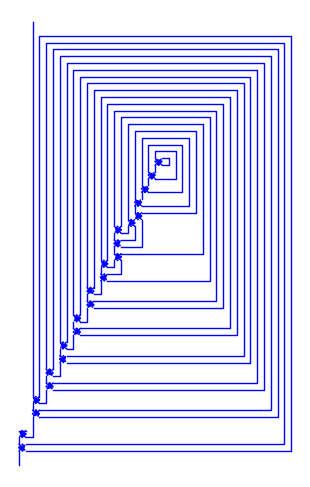

In [91]:
knot = Knots().from_table(3,1)

for i in range(10):
    knot = glide(knot)
G = arrange_crossings(knot)

G.show(figsize=[5,5])

In [92]:
#for 1 tangles
T.<t> = LaurentPolynomialRing(ZZ)

coloring = {0:[255,255,255], # white
            T(t):[255,0,0],  # red
            T(-1):[0,0,255], # blue
            T(1-t):[0,255,0]}# green 

colorize_incd_mat = lambda m: [ [ coloring[j] for j in i] for i in m]

def get_incd_mat(link):
    
    gauss, signs = link.oriented_gauss_code()
    gauss = gauss[0]
    glen = len(gauss)
    
    columns = []
    for i in gauss:
        if abs(i) not in columns:
            columns += [abs(i)] 
    # we pad the gauss code with itself, so that it's easier to find the over strands later
    pgauss = [gauss[-1]] + gauss + [gauss[0]]
    
    entries = [ [abs(pgauss[ent])-1,
                 abs(pgauss[ent+2])-1]
               for ent in [ gauss.index(-i) for i in columns]]
        
    size = len(signs)
    mat = np.full((size,)*2, T(0))
    
    for c,[i,j] in zip([ i-1 for i in columns],entries):
        s = signs[c]
        mat[c][c] = T(1-t)
        if s == 1:
            mat[j][c] = T(t)
            mat[i][c] = T(-1)
        else:
            mat[j][c] = T(-1)
            mat[i][c] = T(t)

            return mat

In [ ]:
# code to produce incidence matrices of the tangle diagrams
import os

knot_names = [ (n,j) for n,i in enumerate([1,1,2,3,7,21,49,165],3) for j in range(1,i+1)]
pas = 0
for knot in knot_names:
    frames = 50
    video_name = "video_"+str(knot[0])+"_"+str(knot[1])+"_"+str(frames)+".avi"
    knot = Knots().from_table(*knot).mirror_image()


    for i in range(frames):
        nodes = arrange_crossings(knot)
        
        img = Image.fromarray(np.array(colorize_alex_mat(get_alex_matrix(knot)),dtype='uint8'),'RGB')
        img = img.resize((600,600), resample=Image.NEAREST)#Image.BOX)
        image_name = './' + str(i) + '.png'
        img.save(image_name)
        knot = glide(knot)

    # need to have ffmeg installed on system
    os.system("ffmpeg -f image2 -r 2 -i ./%01d.png -vcodec huffyuv -y ./"+video_name)
    os.system("rm ./*.png")


In [84]:
# checking how the algorithm differs for the same tangle but with an added R1 move in between

knot = Knots().from_table(3,1)
knot, signs = knot.oriented_gauss_code()
knot = knot[0]
c = len(signs)
    

knot_names = [ [Knot([[knot[:i]+[c+1,-(c+1)]+knot[i:]],signs + [1]]),
                Knot([[knot[:i]+[c+1,-(c+1)]+knot[i:]],signs + [-1]])] for i in range(len(knot)+1)]

knot_names = flatten(knot_names)

for n, knot in enumerate(knot_names):
    
    frames = 50
    G = arrange_crossings(knot)
    G.save('3_1_ed_'+str(n)+'.png')
    
    for i in range(frames):
        knot = glide(knot)
    
    img = Image.fromarray(np.array(colorize_alex_mat(get_alex_matrix(knot)),dtype='uint8'),'RGB')
    img = img.resize((600,600), resample=Image.NEAREST)#Image.BOX)
    image_name = './tests_with_3_1/' + str(n) +'_'+ str(frames) + '.png'
    img.save(image_name)

